In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import random_split
from torchsummary import summary
import time
import numpy as np

In [ ]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out



class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_layers = 4, dropout= 0.3 ,num_channels=[64, 128, 256, 512] , avg_pool_kernel_s=4, num_classes=10):
    super(ResNet, self).__init__()
    assert len(num_channels) == num_layers
    assert len(num_blocks) == num_layers
    self.in_planes = 64
    self.avg_pool_kernel_s = avg_pool_kernel_s
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    layers = []
    for i in range(num_layers):
      stride = 1 if i == 1 else 2
      layers.append(nn.Dropout2d(p=dropout))
      layers.append( self._make_layer(block, num_channels[i], num_blocks[i], stride=stride))
    self.layers = nn.Sequential(*layers)
    self.linear = nn.Linear(num_channels[-1]*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layers(out)
    out = F.avg_pool2d(out, self.avg_pool_kernel_s)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [ ]:
# If GPU available, the code uses it. Otherwise cpu is used for the training (not recommended).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load and normalize CIFAR-10

In [ ]:
torch.manual_seed(42)
BATCH_SIZE_TRAIN = 200
BATCH_SIZE_TEST = 1000
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
total_size = len(trainset)
train_size = int(0.9 * total_size)
validation_size = total_size - train_size

# Split the dataset
generator = torch.Generator().manual_seed(42)
trainset, validationset = torch.utils.data.random_split(trainset, [train_size, validation_size], generator)


In [ ]:
#Augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset.dataset.transform = train_transform

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE_TRAIN,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE_TEST,shuffle=False)
validation_loader = torch.utils.data.DataLoader(validationset,batch_size=BATCH_SIZE_TRAIN,shuffle=False)

In [ ]:
def train_epoch(model, optimizer, scheduler, data_loader, loss_history, criterion):
  total_samples = len(data_loader.dataset)
  model.train()
  for i, (data, target) in enumerate(data_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
      print('[' + '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
      ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)] Loss: ' +
      '{:6.4f}'.format(loss.item()))
  loss_history.append(loss.item())
  scheduler.step()

In [ ]:
def evaluate(model, data_loader, loss_history, criterion):
  model.eval()
  total_samples = len(data_loader.dataset)
  correct_samples = 0
  losses = []
  with torch.no_grad():
    for data, target in data_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = criterion(output, target)
      _, pred = torch.max(output, dim=1)

      losses.append(loss.item())
      correct_samples += pred.eq(target).sum()

  avg_loss = np.mean(losses)
  loss_history.append(avg_loss)
  print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
  ' Accuracy:' + '{:5}'.format(correct_samples) + '/' + '{:5}'.format(total_samples) + ' (' +
  '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [ ]:
num_epochs = 100
model = ResNet(BasicBlock, [2, 2, 2, 2], num_layers = 4, dropout= 0.3 ,num_channels=[40, 80, 160, 320] , avg_pool_kernel_s=4, num_classes=10)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.00001)  # eta_min is the minimum lr
criterion = nn.CrossEntropyLoss()
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 40, 16, 16]          23,040
       BatchNorm2d-5           [-1, 40, 16, 16]              80
            Conv2d-6           [-1, 40, 16, 16]          14,400
       BatchNorm2d-7           [-1, 40, 16, 16]              80
            Conv2d-8           [-1, 40, 16, 16]           2,560
       BatchNorm2d-9           [-1, 40, 16, 16]              80
       BasicBlock-10           [-1, 40, 16, 16]               0
           Conv2d-11           [-1, 40, 16, 16]          14,400
      BatchNorm2d-12           [-1, 40, 16, 16]              80
           Conv2d-13           [-1, 40, 16, 16]          14,400
      BatchNorm2d-14           [-1, 40,

In [ ]:
best_val_loss = np.inf  # Track the highest validation accuracy

start_time = time.time()
train_loss_history, valid_loss_history = [], []
termination_count = 0 #If valid loss does not decrease in 5 consecutive epochs terminate the training
for epoch in range(1, num_epochs + 1):
  print('Epoch:', epoch)
  train_epoch(model, optimizer, scheduler, train_loader, train_loss_history, criterion)
  evaluate(model, validation_loader, valid_loss_history, criterion)
  if valid_loss_history[-1] < best_val_loss:
  #Save the best model in terms of validation loss.
    torch.save(model.state_dict(), 'best_model.pth')
    best_val_loss = valid_loss_history[-1]
    termination_count = 0
  else:
    termination_count = termination_count + 1
  if termination_count >= 5:
    break
print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/45000 (  0%)] Loss: 2.4272
[20000/45000 ( 44%)] Loss: 1.8702
[40000/45000 ( 89%)] Loss: 1.8293

Average test loss: 1.6429 Accuracy: 1888/ 5000 (37.76%)

Epoch: 2
[    0/45000 (  0%)] Loss: 1.6219
[20000/45000 ( 44%)] Loss: 1.5670
[40000/45000 ( 89%)] Loss: 1.6014

Average test loss: 1.4419 Accuracy: 2364/ 5000 (47.28%)

Epoch: 3
[    0/45000 (  0%)] Loss: 1.5706
[20000/45000 ( 44%)] Loss: 1.4461
[40000/45000 ( 89%)] Loss: 1.3870

Average test loss: 1.3381 Accuracy: 2522/ 5000 (50.44%)

Epoch: 4
[    0/45000 (  0%)] Loss: 1.3626
[20000/45000 ( 44%)] Loss: 1.4199
[40000/45000 ( 89%)] Loss: 1.2870

Average test loss: 1.2262 Accuracy: 2815/ 5000 (56.30%)

Epoch: 5
[    0/45000 (  0%)] Loss: 1.1707
[20000/45000 ( 44%)] Loss: 1.3014
[40000/45000 ( 89%)] Loss: 1.3195

Average test loss: 1.0867 Accuracy: 3036/ 5000 (60.72%)

Epoch: 6
[    0/45000 (  0%)] Loss: 1.2041
[20000/45000 ( 44%)] Loss: 1.1986
[40000/45000 ( 89%)] Loss: 1.1104

Average test loss: 1.0496 Accuracy: 3125/ 5

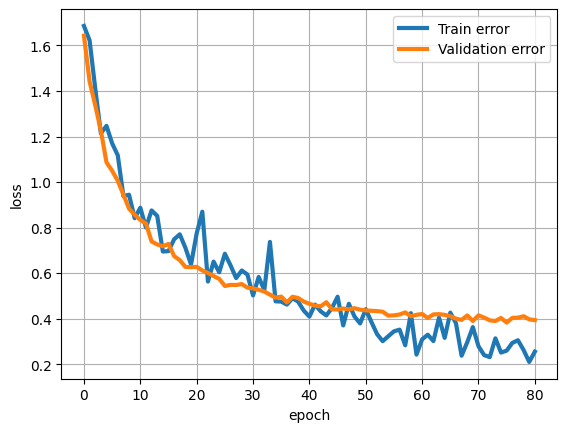

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(valid_loss_history,'-',linewidth=3,label='Validation error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
%matplotlib inline
plt.show()

In [ ]:
evaluate(model, test_loader, [], criterion)


Average test loss: 0.3386 Accuracy: 8940/10000 (89.40%)

